# Deep Convolution Network - Image Recognition - CIFS 10 

In [ ]:
%pip install -q keras-tuner numpy imageio pydot tensorflow-gpu==2.9.1 keras

In [1]:
import os
import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision
import tensorflow.keras.datasets.cifar100


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        mixed_precision.set_global_policy('mixed_float16')
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# initialize tf.distribute.MirroredStrategy
strategy = tf.distribute.MirroredStrategy(devices=None)
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3070 Ti, compute capability 8.6


2022-06-05 12:01:00.981633: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-05 12:01:01.004598: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-05 12:01:01.004764: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-05 12:01:01.005599: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.9.1


### Configure Output Directory
Set the output directory where all the results will be storaged.

In [ ]:
root_dir = "result/fashion_CNN_image_recognition"
if not os.path.exists(root_dir):
    os.mkdir(root_dir)

## Setup DataSet

In [4]:
def loadDataFashion():
    (train_images, train_labels), (test_images, test_labels) = tensorflow.keras.datasets.fashion_mnist.load_data()
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

    TrainX = np.concatenate((train_images, test_images))
    TrainY = np.squeeze(np.concatenate((train_labels, test_labels)))
    TrainX = 2.0 * (TrainX / 255.0) - 1.0
    TrainX = np.expand_dims(TrainX, axis=-1) # <--- add batch axis

    return TrainX, TrainY, class_names


In [5]:

EPOCH = 48
BUFFER_SIZE = 192
BATCH_SIZE = 256

trainX, trainY, classes = loadDataFashion()
IMAGE_SIZE = trainX[0].shape


## Show Example of DataSet

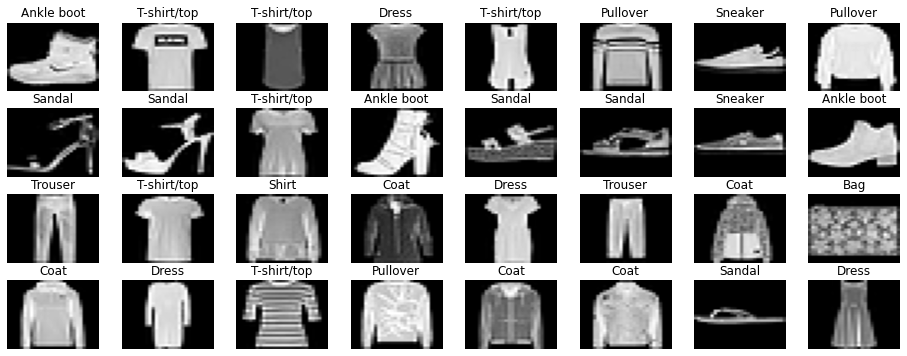

In [6]:
fig = plt.figure(figsize=(16, 6))
nrImage = 4 * 8
for index, (image, label) in enumerate(zip(trainX[0:nrImage], trainY[0:nrImage])):
    plt.subplot(4, 8, (index + 1))
    plt.title(label=str.format("{0}", classes[label]))

    plt.imshow(X=((image + 1.0) / 2.0).astype(dtype='float32'), cmap=plt.cm.gray, aspect='auto')
    plt.axis("off")
plt.subplots_adjust(wspace=0.25, hspace=0.25)
plt.show(block=False)


In [7]:
def plotCostHistory(history, loss_label="", val_label="", title="", x_label="", y_label=""):
    plt.figure()
    for k, v in history.items():
        plt.plot(v, label=k)
    plt.title(label=title)
    plt.ylabel(ylabel=y_label)
    plt.xlabel(xlabel=x_label)
    plt.legend(loc="upper left")
    plt.show(block=False)
    plt.savefig(title + ".png")


## Create Network with Hyperparameter
By using hyperparameter, a set of possible neuron network configuration can be setup. This allows to find network that are more optimal.

SparseCategoricalCrossentropy is used as the loss function. But also that it generates one-hot vector from an integer value that represents the categorical.

In [8]:

def generate_cnn_builder(hp, input, output):
    cnn_model = tf.keras.Sequential()
    #
    kernel_init = hp.Choice('kernel_initializer', ['uniform', 'lecun_uniform', 'normal', 'zero',
                                                   'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'])

    hp_kernel_filter_size_l0 = hp.Int(
        'kernel_filter_size_0', min_value=32, max_value=512, step=32)
    hp_kernel_filter_size_l1 = hp.Int(
        'kernel_filter_size_1', min_value=32, max_value=512, step=32)

    hp_strides_size_l0 = hp.Int(
        'hp_strides_size_l0', min_value=1, max_value=2, step=1)
    hp_strides_size_l1 = hp.Int(
        'hp_strides_size_l1', min_value=1, max_value=2, step=1)

    hp_kernel_size_l0 = hp.Int(
        'hp_kernel_size_l0', min_value=3, max_value=7, step=2)
    hp_kernel_size_l1 = hp.Int(
        'hp_kernel_size_l1', min_value=3, max_value=7, step=2)

    hp_max_pooling_size_l0 = hp.Int(
        'max_pooling_l0', min_value=1, max_value=3, step=1)
    hp_max_pooling_size_l1 = hp.Int(
        'max_pooling_l1', min_value=1, max_value=2, step=1)

    cnn_model.add(
        layers.Conv2D(filters=hp_kernel_filter_size_l0, kernel_size=(3, 3), strides=hp_strides_size_l0,
                      kernel_initializer=kernel_init, activation='relu',
                      padding='same',
                      input_shape=input))
    cnn_model.add(layers.MaxPooling2D(pool_size=hp_max_pooling_size_l0))

    cnn_model.add(
        layers.Conv2D(filters=hp_kernel_filter_size_l1, kernel_size=(3, 3), strides=hp_strides_size_l1,
                      activation='relu', padding='same', kernel_initializer=kernel_init))
    cnn_model.add(layers.MaxPooling2D(pool_size=hp_max_pooling_size_l1))

    cnn_model.add(layers.Flatten())

    hp_units = hp.Int('dense0_units', min_value=32, max_value=512, step=32)
    cnn_model.add(layers.Dense(units=hp_units, kernel_initializer=kernel_init))
    cnn_model.add(layers.Dense(units=output))

    cnn_model.summary()

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    cnn_model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                      loss=keras.losses.SparseCategoricalCrossentropy(
                          from_logits=True),
                      metrics=['accuracy'])

    return cnn_model


## Training
First the dataset is split into training and test data.

kt.Hyperband is used as the hyperparameter manager, where the model_builder is the function that will construct the convolutional network.

tuner.search will search the whole hyperparameter space and select the one that is best, and to prevent it having to run all epoch, an EarlyStopping is used to valdiate if the model performance good or not in the early stage of the learning.

In [9]:
# Neuron network input and output.
image_shape = trainX[0].shape
num_classes_output = len(classes)

train_X, test_X, train_y, test_y = train_test_split(
    trainX, trainY, shuffle=True, test_size=0.25)

print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  ' + str(test_X.shape))
print('Y_test:  ' + str(test_y.shape))

def model_builder(hp):
    model = generate_cnn_builder(hp, image_shape, num_classes_output)
    return model


tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=16,
                     factor=3,
                     directory='cache',
                     project_name=str.format('{0}/cnn - {1}', root_dir, "Fashion"))

stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5)
tuner.search(train_X, train_y, validation_split=0.1, epochs=EPOCH, batch_size=BATCH_SIZE,
             callbacks=[stop_early], verbose=1)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

cnn_model = tuner.hypermodel.build(best_hps)
cnn_model.summary()


X_train: (52500, 28, 28, 1)
Y_train: (52500,)
X_test:  (17500, 28, 28, 1)
Y_test:  (17500,)
INFO:tensorflow:Reloading Oracle from existing project cache/cnn - Fashion/oracle.json
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 28, 28, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 flatten 

2022-06-05 12:01:02.531598: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-05 12:01:02.532397: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-05 12:01:02.532566: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-05 12:01:02.532672: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 480)       4800      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 480)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 320)         1382720   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 320)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 15680)             0         
                                                                 
 dense (Dense)               (None, 128)               2

## Training the Best Model
Now the best model that was selected is constructed and trained on.

In [10]:

checkpoint_path = str.format("{0}/fashion_cnn/cp.ckpt", root_dir)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=0)
checkpoint = tf.train.Checkpoint(model=cnn_model)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path)).expect_partial()


# The model weights (that are considered the best) are loaded into the model.
if os.path.exists(checkpoint_path):
    cnn_model.load_weights(checkpoint_path)

cnn_model_history = cnn_model.fit(train_X, train_y, epochs=EPOCH, batch_size=BATCH_SIZE)

cnn_model.save_weights(checkpoint_path)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 480)       4800      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 480)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 320)         1382720   
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 320)        0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 15680)             0         
                                                                 
 dense_2 (Dense)             (None, 128)              

2022-06-05 12:01:06.789489: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400
2022-06-05 12:01:07.619933: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


206/206 [==============================] - 8s 23ms/step - loss: 0.4462 - accuracy: 0.8403
Epoch 2/48
206/206 [==============================] - 4s 22ms/step - loss: 0.2810 - accuracy: 0.9002
Epoch 3/48
206/206 [==============================] - 5s 22ms/step - loss: 0.2364 - accuracy: 0.9143
Epoch 4/48
206/206 [==============================] - 4s 22ms/step - loss: 0.2007 - accuracy: 0.9271
Epoch 5/48
206/206 [==============================] - 4s 22ms/step - loss: 0.1755 - accuracy: 0.9369
Epoch 6/48
206/206 [==============================] - 4s 22ms/step - loss: 0.1545 - accuracy: 0.9444
Epoch 7/48
206/206 [==============================] - 5s 22ms/step - loss: 0.1329 - accuracy: 0.9519
Epoch 8/48
206/206 [==============================] - 5s 22ms/step - loss: 0.1178 - accuracy: 0.9569
Epoch 9/48
206/206 [==============================] - 5s 22ms/step - loss: 0.1011 - accuracy: 0.9640
Epoch 10/48
206/206 [==============================] - 4s 22ms/step - loss: 0.0966 - accuracy: 0.9648


## Final Result

In [11]:
val_acc_per_epoch = cnn_model_history.history['accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: {0}'.format(best_epoch,))

cnn_model.evaluate(test_X, test_y, verbose=2)


Best epoch: 47
547/547 - 1s - loss: 0.7237 - accuracy: 0.9095 - 900ms/epoch - 2ms/step


[0.7237001657485962, 0.9095428586006165]

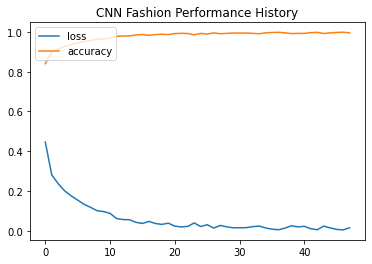

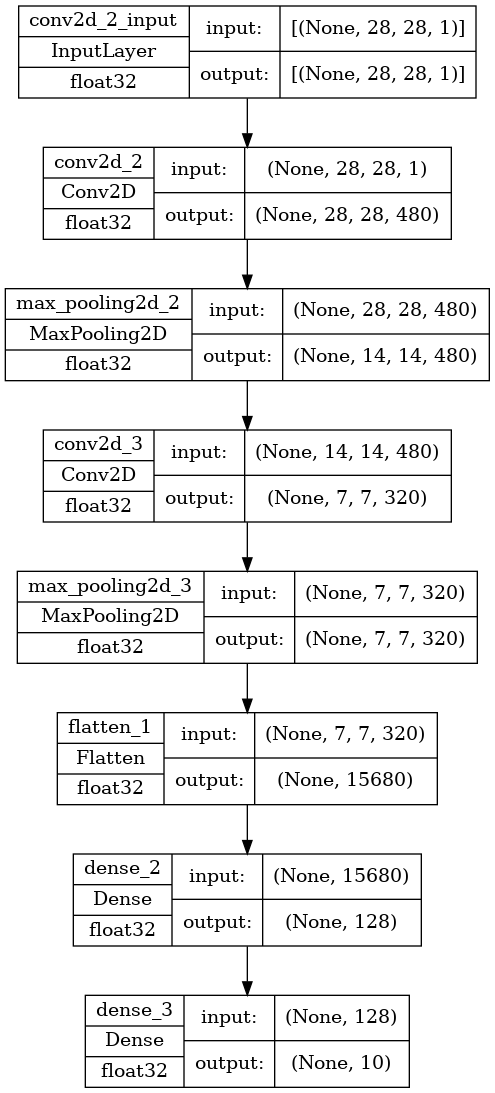

<Figure size 432x288 with 0 Axes>

In [12]:
plotCostHistory(cnn_model_history.history, title=str.format(
    "CNN {0} Performance History", "Fashion"))

tf.keras.utils.plot_model(
    cnn_model, to_file=str.format('cnn_{0}_model.png', "Fashion"), show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None
)
